## Mitigatin the Fairness Issues using Post-Processing: Threshold Adjustment

This method tries to find (sensitive) group-specific thresholds for a given estimator. The thresholds are chosen to optimize the provided performance objective subject to the provided fairness constraints.


In [88]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover
from sklearn.pipeline import Pipeline
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer



In [89]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

In [90]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train = X_train['Sex']
sensitive_test = X_test['Sex']

The `ThresholdOptimizer` receives a sklearn pipeline as input, that makes it more flexible with multi-step pipleines.

In [91]:
pipeline = Pipeline(
    steps=[
        ("classifier",RandomForestClassifier(random_state=42)),
    ]
)

The performance objective and the fairness constraints should be decided as inputs to the threshold optimizer:

C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


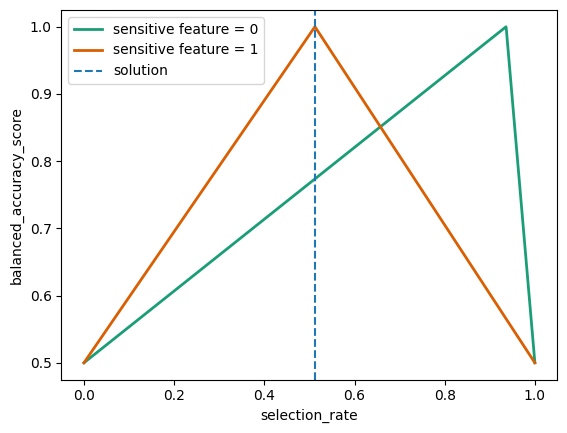

In [92]:
threshold_optimizer = ThresholdOptimizer(
    estimator=pipeline,
    objective="balanced_accuracy_score",
    constraints="demographic_parity",
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train)

plot_threshold_optimizer(threshold_optimizer)

In [93]:
y_pred = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8015873015873016


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

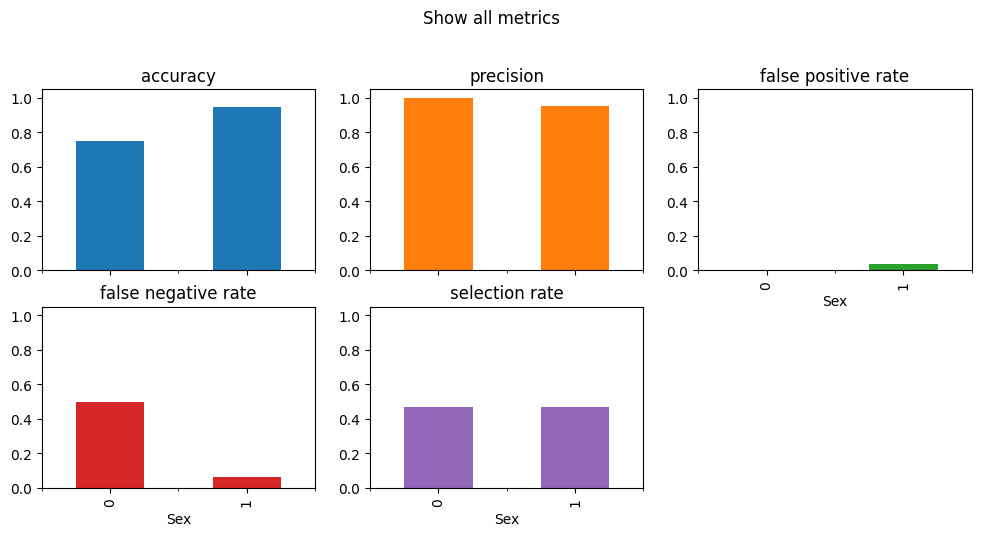

In [94]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)


In [95]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.0024038461538461453
Statistical Parity ratio: 0.9948979591836735
Equalized Odds Difference: 0.4347826086956522
Equalized Odds Ratio: 0.0


**Exercise 4.6:** Have a look at the documentation of threshold optimizer function in Fairlearn at https://fairlearn.org/v0.9/api_reference/generated/fairlearn.postprocessing.ThresholdOptimizer.html and learn more about how to use it. Use Equalized Odds (instead of demographic parity) as constraint and report the final results.

**Exercise 4.7:** plot two scatter plots with balanced accuracy as x-axis and statistical parity difference/Equalized odds difference as y-axis for 6 different approaches we have presented in the lecture (naive approach, resampling, removing correlation, reweighting, exponentiated gradients, and threshold adjustment). Which one performs the best in this data? 

##### 4.6

In [104]:
threshold_optimizer = ThresholdOptimizer(
    estimator=pipeline,
    objective="balanced_accuracy_score",
    constraints="equalized_odds",
)
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train) # throws an error because X_train/test are data frames and not arrays

plot_threshold_optimizer(threshold_optimizer)

C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyError: 0

##### 4.7
naive approach

In [97]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 
X_train = X_train.drop(columns=['Sex'])
sensitive_test = X_test['Sex']
X_test = X_test.drop(columns=['Sex'])

# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Measure accuracy, parity difference, equalized odds
accuracy_naive = balanced_accuracy_score(y_test, y_pred)

stat_parity_diff_naive = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)

equal_odds_diff_naive = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


resampling

In [98]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
df = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
df.loc[df['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias
df['Loan_Approval'] = 0
df.loc[(df['Sex'] == 0) & (df['Credit_Score']/650 + df['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
df.loc[(df['Sex'] == 1) & (df['Credit_Score']/650 + df['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1


# Split data
train, test = train_test_split(df, test_size=0.2, random_state=42)

group_0 = train[train['Sex'] == 0]
group_1 = train[train['Sex'] == 1]

# Function to resample each subgroup to have the same number of samples
def resample_group(df, group_size):
    return df.sample(n=group_size, replace=True, random_state=42)

# Calculate the smallest number of samples among the groups
min_group_size = min(len(group_0[group_0['Loan_Approval'] == 1]), len(group_1[group_1['Loan_Approval'] == 1]))

# Resample each group to have the same number of samples
group_0_approved = resample_group(group_0[group_0['Loan_Approval'] == 1], min_group_size)
group_1_approved = resample_group(group_1[group_1['Loan_Approval'] == 1], min_group_size)

group_0_rejected = resample_group(group_0[group_0['Loan_Approval'] == 0], min_group_size)
group_1_rejected = resample_group(group_1[group_1['Loan_Approval'] == 0], min_group_size)

# Combine the resampled data back
train_resampled = pd.concat([group_0_approved, group_0_rejected, group_1_approved, group_1_rejected])

# Shuffle the resampled data
train_resampled = train_resampled.sample(frac=1).reset_index(drop=True)

# Prepare data for model training
X_train_resampled = train_resampled.drop(columns=['Loan_Approval', 'Sex'])
y_train_resampled = train_resampled['Loan_Approval']

X_test = test.drop(columns=['Loan_Approval','Sex'])
y_test = test['Loan_Approval']
sensitive_test = test['Sex']

# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]


# Measure accuracy, parity difference, equalized odds
accuracy_resamp = balanced_accuracy_score(y_test, y_pred)

stat_parity_diff_resamp = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)

equal_odds_diff_resamp = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)


removing correlation

In [99]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

cr = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)
X_train_cr = pd.DataFrame(X_train_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])


# Train a Random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:,1]

# Measure accuracy, parity difference, equalized odds
accuracy_corr = balanced_accuracy_score(y_test, y_pred)

stat_parity_diff_corr = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)

equal_odds_diff_corr = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


reweighting

In [100]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train = X_train['Sex']
sensitive_test = X_test['Sex']
X_train = X_train.drop(columns=['Sex'])
X_test = X_test.drop(columns=['Sex'])

# Calculate selection rate for each sensitive group
selection_rate_male = y_train[sensitive_train == 0].mean()
selection_rate_female = y_train[sensitive_train == 1].mean()

# Calculate inverse of selection rate
inverse_rate_male = 1 / selection_rate_male[0] if selection_rate_male[0] > 0 else 1
inverse_rate_female = 1 / selection_rate_female[0] if selection_rate_female[0] > 0 else 1

# Normalize the weights to make them sum to the number of samples (keeps the effective size of the dataset unchanged)
normalization_factor = (len(y_train) / (inverse_rate_male * (sensitive_train == 0).sum() + inverse_rate_female * (sensitive_train == 1).sum()))

# Create sample weights based on the sensitive feature
sample_weights = np.ones(len(y_train))
sample_weights[sensitive_train == 0] = inverse_rate_male * normalization_factor
sample_weights[sensitive_train == 1] = inverse_rate_female * normalization_factor

# Train Random Forest classifier with sample weights
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Measure accuracy, parity difference, equalized odds
accuracy_weight = balanced_accuracy_score(y_test, y_pred)

stat_parity_diff_weight = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)

equal_odds_diff_weight = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

C:\Users\lukac\AppData\Local\Temp\ipykernel_14976\1297259507.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inverse_rate_male = 1 / selection_rate_male[0] if selection_rate_male[0] > 0 else 1
C:\Users\lukac\AppData\Local\Temp\ipykernel_14976\1297259507.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inverse_rate_female = 1 / selection_rate_female[0] if selection_rate_female[0] > 0 else 1
C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d

exponentiated gradients

In [101]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_train = X_train['Sex']
sensitive_test = X_test['Sex']

pipeline = Pipeline(
    steps=[
        ("classifier",RandomForestClassifier(random_state=42)),
    ]
)

exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight"
)
exponentiated_gradient.fit(X_train, y_train, sensitive_features=sensitive_train)
y_pred = exponentiated_gradient.predict(X_test)


# Measure accuracy, parity difference, equalized odds
accuracy_eg = balanced_accuracy_score(y_test, y_pred)

stat_parity_diff_eg = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)

equal_odds_diff_eg = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)

C:\Users\lukac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sel

plots

In [102]:
data = {
    'Approach': ['Naive', 'Resampling', 'Removing Correlation', 'Reweighting', 'Exponentiated Gradients', 'Threshold Adjustment'],
    'Balanced Accuracy': [accuracy_naive, accuracy_resamp, accuracy_corr, accuracy_weight, accuracy_eg, accuracy],  # Example values
    'Statistical Parity Difference': [stat_parity_diff_naive, stat_parity_diff_resamp, stat_parity_diff_corr, stat_parity_diff_weight, stat_parity_diff_eg, stat_parity_diff],  # Example values
    'Equalized Odds Difference': [equal_odds_diff_naive, equal_odds_diff_resamp, equal_odds_diff_corr, equal_odds_diff_weight, equal_odds_diff_eg, equal_odds_diff] 
}

df = pd.DataFrame(data)
print(df)


                  Approach  Balanced Accuracy  Statistical Parity Difference  \
0                    Naive           0.872024                       0.300481   
1               Resampling           0.862103                       0.224359   
2     Removing Correlation           0.790675                       0.141026   
3              Reweighting           0.886409                       0.291667   
4  Exponentiated Gradients           0.850198                       0.116987   
5     Threshold Adjustment           0.801587                       0.002404   

   Equalized Odds Difference  
0                   0.240000  
1                   0.200000  
2                   0.360000  
3                   0.200000  
4                   0.323869  
5                   0.434783  


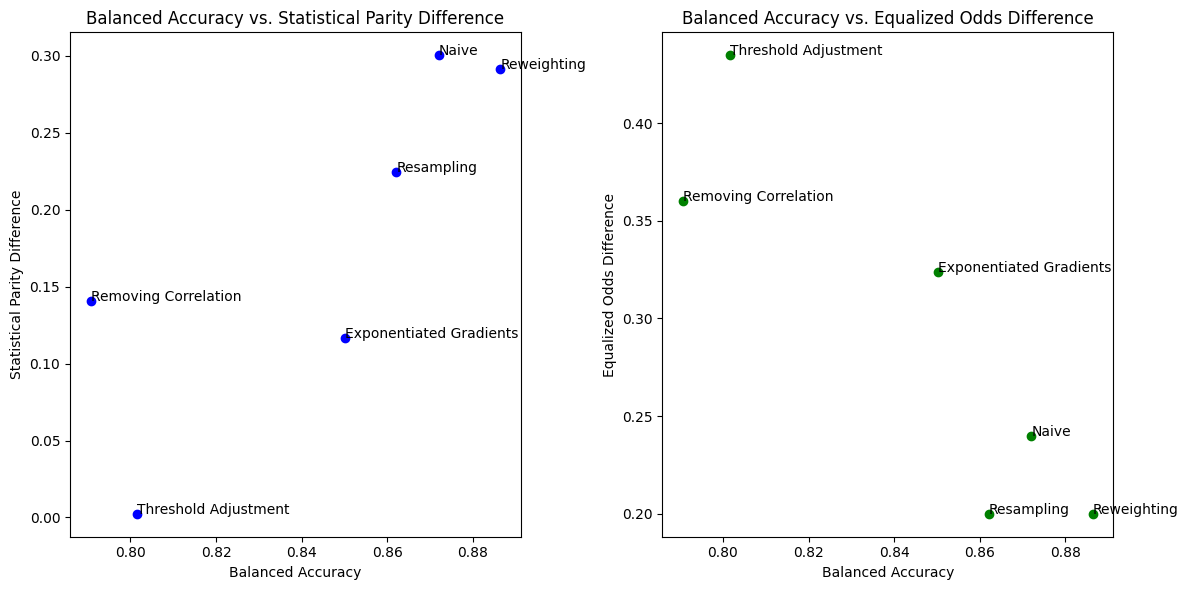

In [103]:
import matplotlib.pyplot as plt

# Scatter Plot 1: Balanced Accuracy vs. Statistical Parity Difference
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['Balanced Accuracy'], df['Statistical Parity Difference'], color='blue')

# Add labels and title
for i, txt in enumerate(df['Approach']):
    plt.annotate(txt, (df['Balanced Accuracy'][i], df['Statistical Parity Difference'][i]), fontsize=10)

plt.title('Balanced Accuracy vs. Statistical Parity Difference')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Statistical Parity Difference')

# Scatter Plot 2: Balanced Accuracy vs. Equalized Odds Difference
plt.subplot(1, 2, 2)
plt.scatter(df['Balanced Accuracy'], df['Equalized Odds Difference'], color='green')

# Add labels and title
for i, txt in enumerate(df['Approach']):
    plt.annotate(txt, (df['Balanced Accuracy'][i], df['Equalized Odds Difference'][i]), fontsize=10)

plt.title('Balanced Accuracy vs. Equalized Odds Difference')
plt.xlabel('Balanced Accuracy')
plt.ylabel('Equalized Odds Difference')

# Show plots
plt.tight_layout()
plt.show()
